# MLP classifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import  matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Import of data based on feature selection resutls

In [50]:
X = pd.read_table('../data/data/x_train.txt', header=None, delimiter=' ')
y = pd.read_table('../data/data/y_train.txt', header=None)
X_test_submission = pd.read_table('../data/data/x_test.txt', header=None, delimiter=' ')

# based on feature selection investigation
selected_features = [100, 101, 102, 103, 104, 105]
X = X[selected_features]
X_test_submission = X_test_submission[selected_features]

In [79]:
def predict(clf, X_test, n_max_positive):
  probabilities = clf.predict_proba(X_test)
  probabilities = probabilities[:, 1]

  top_n_indices = np.argsort(probabilities)[-n_max_positive:]
  y_pred = np.zeros(X_test.shape[0])
  y_pred[top_n_indices] = 1
  return y_pred

def train_mlp(X_train, y_train, X_test, y_test, n_max_positive):
  clf = MLPClassifier(random_state=2024, max_iter=500, activation='tanh', verbose=False)
  clf.fit(X_train, y_train)

  y_pred = predict(clf, X_test, n_max_positive)
  return accuracy_score(y_test, y_pred)

In [80]:
experiment_name = 'squared'
X_squared = X.apply(lambda x: x**2)

X_train, X_test, y_train, y_test = train_test_split(X_squared, y, test_size=0.2, random_state=2024, stratify=y)

accuracy_results = []
n_max_positive = y_test[y_test[0] == 1].shape[0]


accuracy_results.append(train_mlp(X_train, y_train, X_test, y_test, n_max_positive))

for f in selected_features:
  accuracy_results.append(train_mlp(X_train[[f]], y_train, X_test[[f]], y_test, n_max_positive))

np.save(f'mlp_results/{experiment_name}.npy', accuracy_results)
accuracy_results

[0.73, 0.564, 0.528, 0.558, 0.546, 0.542, 0.592]

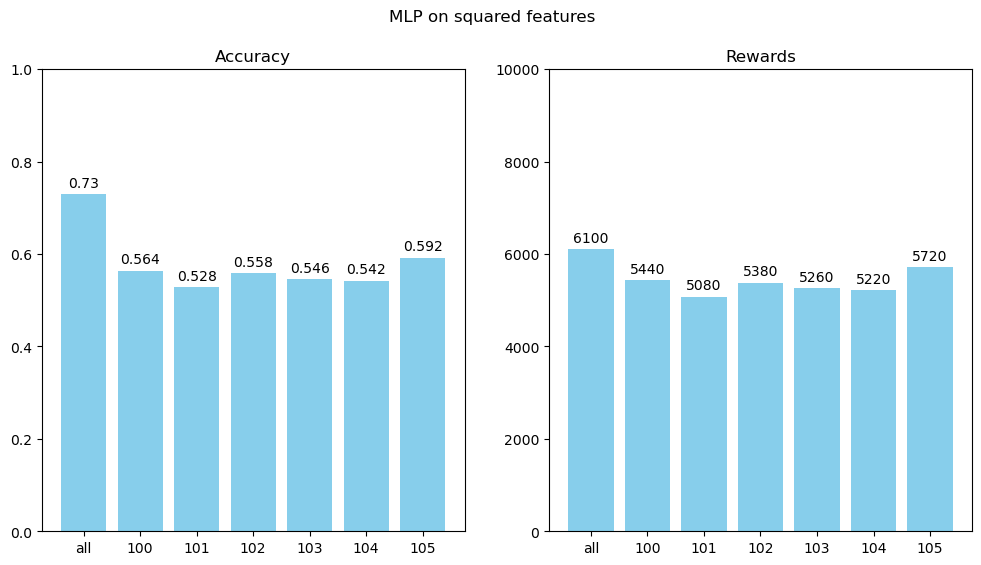

In [78]:
def calc_expected_reward(accuracy, n_features, n_max_positive = 1000):
  return int((n_max_positive * accuracy)) * 10 - n_features * 200

results = np.load('mlp_results/squared.npy')
n_features = [6, 1, 1, 1, 1, 1, 1]

rewards = []
for i, result in enumerate(results):
  rewards.append(calc_expected_reward(result, n_features[i]))

def add_value_labels(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('MLP on squared features')

rects1 = axs[0].bar(['all'] + [str(x) for x in selected_features], results, color='skyblue')
axs[0].set_title('Accuracy')
axs[0].set_ylim(0, 1)
add_value_labels(axs[0], rects1)

rects2 = axs[1].bar(['all'] + [str(x) for x in selected_features], rewards, color='skyblue')
axs[1].set_title('Rewards')
axs[1].set_ylim(0, 10000)
add_value_labels(axs[1], rects2)